In [4]:
import os
import glob

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2

from keras.preprocessing import image
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout, UpSampling2D

In [0]:
%matplotlib inline

(420, 540)


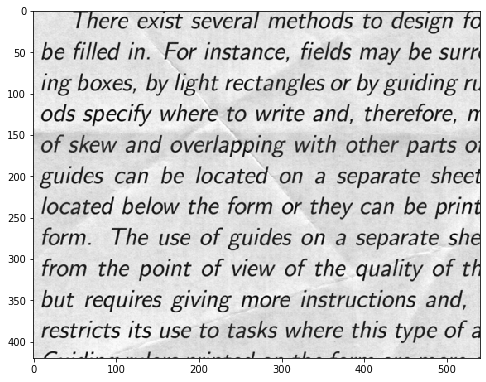

In [6]:
plt.figure(figsize=(8,8))
img = cv2.imread('train/101.png', 0)
plt.imshow(img, cmap='gray')
print(img.shape)

In [0]:
TRAIN_IMAGES = glob.glob('train/*.png')
CLEAN_IMAGES = glob.glob('train_cleaned/*.png')
TEST_IMAGES = glob.glob('test/*.png')

In [0]:
def load_image(path):
    image_list = np.zeros((len(path), 258, 540, 1))
    for i, fig in enumerate(path):
        img = image.load_img(fig, color_mode='grayscale', target_size=(258, 540))
        x = image.img_to_array(img).astype('float32')
        x = x / 255.0
        image_list[i] = x
    
    return image_list

In [11]:
x_train = load_image(TRAIN_IMAGES)
y_train = load_image(CLEAN_IMAGES)
x_test = load_image(TEST_IMAGES)

print(x_train.shape, x_test.shape)


(144, 258, 540, 1) (72, 258, 540, 1)


In [12]:
def train_val_split(x_train, y_train):
    rnd = np.random.RandomState(seed=42)
    perm = rnd.permutation(len(x_train))
    train_idx = perm[:int(0.8 * len(x_train))]
    val_idx = perm[int(0.8 * len(x_train)):]
    return x_train[train_idx], y_train[train_idx], x_train[val_idx], y_train[val_idx]

x_train, y_train, x_val, y_val = train_val_split(x_train, y_train)
print(x_train.shape, x_val.shape)

(115, 258, 540, 1) (29, 258, 540, 1)


In [0]:
noisy_train=y_train-x_train
noisy_valid=y_val-x_val

In [0]:
class Autoencoder():
    def __init__(self):
        self.img_rows = 258
        self.img_cols = 540
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        optimizer = Adam(lr=0.001)
        
        self.autoencoder_model = self.build_model()
        self.autoencoder_model.compile(loss=['binary_crossentropy','binary_crossentropy'], optimizer=optimizer)
        self.autoencoder_model.summary()
    
    def build_model(self):
        input_layer = Input(shape=self.img_shape)
        
        # encoder
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
        h = MaxPooling2D((2, 2), padding='same')(h)
        
        # noise decoder
        h_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
        h_2 = UpSampling2D((2, 2))(h_2)
        output_layer2 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(h_2)

        # decoder
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
        h = UpSampling2D((2, 2))(h)
        output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(h)
        
        return Model(input_layer, [output_layer,output_layer2])
    
    def train_model(self, x_train,noisy_train,noisy_valid, y_train, x_val, y_val, epochs, batch_size=20):
        early_stopping = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=5,
                                       verbose=1, 
                                       mode='auto')
        history = self.autoencoder_model.fit(x_train, [y_train,noisy_train],
                                             batch_size=batch_size,
                                             epochs=epochs,
                                             validation_data=(x_val, [y_val,noisy_valid]),
                                             callbacks=[early_stopping])
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()
    
    def eval_model(self, x_test):
        preds = self.autoencoder_model.predict(x_test)
        return preds

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 258, 540, 1)  0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 258, 540, 64) 640         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 129, 270, 64) 0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 129, 270, 64) 36928       max_pooling2d_3[0][0]            
____________________________________________________________________________________________

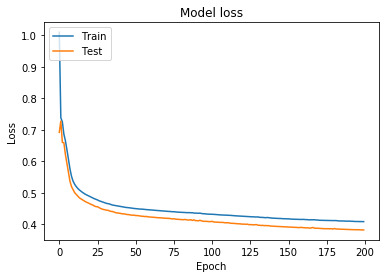

In [48]:
ae = Autoencoder()
ae.train_model(x_train,noisy_train,noisy_valid, y_train, x_val, y_val, epochs=200, batch_size=20)

In [0]:
preds,noisy = ae.eval_model(x_test)

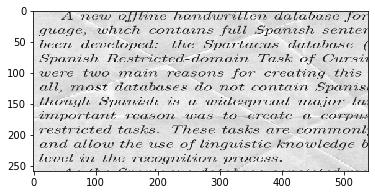

In [51]:
rec=((x_test[10]+noisy[10])* 255.0).reshape(258, 540)
preds_0 = preds[10] * 255.0

preds_0 = preds_0.reshape(258, 540)

x_test_0 = x_test[10] * 255.0


x_test_0 = x_test_0.reshape(258, 540)
plt.imshow(x_test_0, cmap='gray')

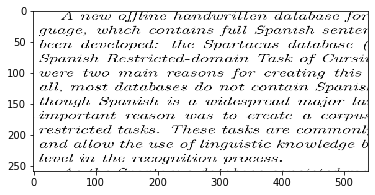

In [52]:
plt.imshow(preds_0, cmap='gray')


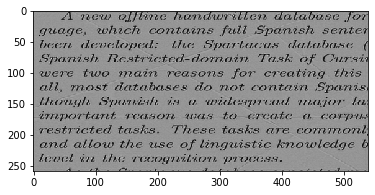

In [53]:
plt.imshow(rec, cmap='gray')
